# Data Ingestion

## Copy CSV files to S3

In [2]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


In [3]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [4]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"

# Destination Data:

s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)

# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"


                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/nyt/nyt-comments-2020.csv


## Create Database, Tables and Parquets
### Database

In [5]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

#!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [6]:
# Create Database
database_name = "dbpoliticpulsecomment"

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


,database_name
0,dbpoliticpulsecomment
1,default


In [7]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [8]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


""


In [9]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,2020-10-21 00:00:01.553481849


In [10]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


""


In [11]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter


In [12]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


### Parquets

In [13]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT 
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
WHERE
    tweet IS NOT NULL or tweet NOT LIKE '%.0' or LENGTH(tweet) > 0
UNION ALL
SELECT 
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
WHERE commentbody is NOT NULL or LENGTH(commentbody) > 0 
or commentid is NOT NULL
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

,rows


In [14]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,106394240.0,Joe Biden would have a much better chance of w...,57807721,Mickey McGovern,San Francisco,2020-04-10 16:02:07,0,16,nyt_comment,3,2,Trump
1,106319464.0,Joe Biden needs to be speaking now! Where is he?,26090123,Kathie,Warrington,2020-04-07 18:02:54,0,3,nyt_comment,0,1,Biden
2,106308376.0,Joe Biden was paid over $20 million last year ...,37435084,Common Ground,New York,2020-04-07 12:03:08,0,3,nyt_comment,0,1,Biden
3,108857760.0,Joe Biden has only recently condemned the loot...,78343265,KMW,New York City,2020-08-28 07:57:53,3,11,nyt_comment,2,1,Trump
4,108861520.0,Joe Biden will give us the absolutely best cha...,60104132,Tom,Bluffton SC,2020-08-28 13:22:13,1,14,nyt_comment,1,1,None


In [15]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [16]:
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT comment_id,
         user_name,
         user_location,
         comment_body,
         reply_retweet,
         recommendation_like,
         source,
         trump_count,
         biden_count,
         candidatepoll
FROM {}.{}""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)


,rows


In [17]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

""


In [18]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,candidatepoll=Biden
1,candidatepoll=__HIVE_DEFAULT_PARTITION__
2,candidatepoll=Trump


In [19]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter


In [20]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    WHERE candidatepoll = '{}' LIMIT 100""".format(
    database_name, table_parquet, candidatepoll
)
df = pd.read_sql(statement, conn)
df.head(5)

,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.322401e+18,AdamIShackleton,,#MinnesotaDemocrats #Dumbasses you all just #S...,0.0,0.0,tweet,2,0,Trump
1,1.322401e+18,Carlos Larios G.,urbana y rural,#AMLO #Trump #Elecciones2020 #USA https://t.co...,0.0,0.0,tweet,1,0,Trump
2,1.322401e+18,Mike Davey,high school coach,@GOPChairwoman @realDonaldTrump After a 36% de...,0.0,0.0,tweet,2,0,Trump
3,1.322402e+18,Cosmicgypsy,TinCanBay,@bornmiserable #trump saying drs lying about i...,0.0,0.0,tweet,2,0,Trump
4,1.322402e+18,doris bourque,,https://t.co/kwAm6UabMX LISEZ CECI = CET HOMME...,1.0,1.0,tweet,1,0,Trump


## Query Data

In [21]:
# Setup and check pre-requisites to create Database

#!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

In [22]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [23]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results_trump = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

df_parquet_results_trump.shape

(1005922, 4)

In [24]:
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""WIN = trump https://t.co/v4yRMK4rrX",tweet,<NA>,Trump
1,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",tweet,<NA>,Trump
2,"""@BrettFavre @realDonaldTrump Principle’s are ...",tweet,<NA>,Trump
3,"""Anything Trump can do",tweet,2626.0,Trump
4,"""Trump is winning.",tweet,<NA>,Trump


In [25]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results_biden = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)

df_parquet_results_biden.shape


(489258, 4)

In [26]:
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden


# Data Exploration

In [28]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005922 entries, 0 to 333283
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   comment_body   1005922 non-null  string  
 1   source         1005922 non-null  string  
 2   user_location  771369 non-null   string  
 3   candidatepoll  1005922 non-null  category
dtypes: category(1), string(3)
memory usage: 31.7 MB


In [29]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489258 entries, 0 to 163918
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   489258 non-null  string  
 1   source         489258 non-null  string  
 2   user_location  331981 non-null  string  
 3   candidatepoll  489258 non-null  category
dtypes: category(1), string(3)
memory usage: 15.4 MB


In [31]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


tweet          605045
nyt_comment    400877
Name: source, dtype: Int64

In [32]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

tweet          425988
nyt_comment     63270
Name: source, dtype: Int64

In [34]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                                                 69044
NYC                                              13813
California                                       12066
New York                                         11647
USA                                               8757
                                                 ...  
 et no alcool 🚱🚭"                                    1
2009-03-15 00:42:39                                  1
 now @nyulaw. Mes opinions 🍸 also I am hungry        1
Brooklin                                             1
2020-02-26 12:55:40                                  1
Name: user_location, Length: 96099, dtype: Int64

In [40]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

                 69044
NYC              13813
California       12066
New York         11647
USA               8757
Chicago           7062
NY                6845
Los Angeles       6800
San Francisco     6381
Seattle           6147
Florida           5789
United States     5745
NJ                5603
Boston            5415
New Jersey        4402
Canada            4310
New York City     4280
Colorado          3861
Brooklyn          3796
Texas             3774
CA                3567
Philadelphia      3267
Oregon            2836
Massachusetts     2834
Virginia          2766
Atlanta           2758
San Diego         2577
NC                2447
Maryland          2434
Midwest           2366
Name: user_location, dtype: Int64

In [39]:
df_parquet_results_biden['user_location'].value_counts()

                                                 52254
United States                                     3657
New York                                          2553
NYC                                               2458
USA                                               2342
                                                 ...  
2015-11-25 10:55:15                                  1
4289.0                                               1
Ankara & Fethiye                                     1
"Garda                                               1
 MH Counselor. Exposing Crime & Corruption in        1
Name: user_location, Length: 75165, dtype: Int64

In [41]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

                 52254
United States     3657
New York          2553
NYC               2458
USA               2342
California        1856
NY                1330
"Los Angeles      1280
"New York         1269
Chicago           1163
Los Angeles       1110
San Francisco     1109
"California       1011
Florida           1010
Seattle           1004
Boston             873
"Washington        847
NJ                 807
Texas              778
Virginia           767
"Florida           740
Canada             734
New York City      731
New Jersey         691
Brooklyn           645
"London            636
0.0                608
CA                 595
"Texas             590
Philadelphia       577
Name: user_location, dtype: Int64

# Create EDA Overview Data Visualization

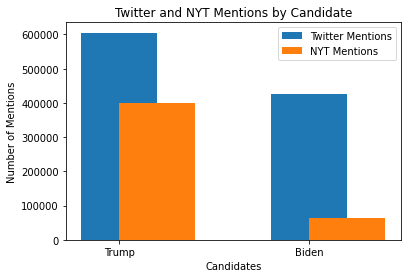

In [48]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [605045,425988]
nyt_n = [400877, 63270]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')
plt.show()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['comment_body'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

In [ ]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['comment_body'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

In [ ]:
import matplotlib.pyplot as plt

# Trump comments
trump_comment_lengths = df_parquet_results_trump['comment_body'].dropna().apply(len)
plt.hist(trump_comment_lengths, bins=30, color='blue', alpha=0.7, label='Trump')

# Biden comments
biden_comment_lengths = df_parquet_results_biden['comment_body'].dropna().apply(len)
plt.hist(biden_comment_lengths, bins=30, color='red', alpha=0.7, label='Biden')

plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths')
plt.legend()
plt.show()

# Sentiment Labels Using Textblob

In [51]:
# Code from ChatGPT
#!pip install textblob
from textblob import TextBlob

def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity

# Apply sentiment labels to Trump Data
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_trump = df_parquet_results_trump[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']
    
    
    
 # Apply Sentiment labels to Biden Data       
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_biden = df_parquet_results_biden[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']
              


/tmp/ipykernel_10174/2515332033.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)
/tmp/ipykernel_10174/2515332033.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)


## Trump

In [52]:
# Examine Trump Sentiment distribution
df_parquet_results_trump['sentiment'].value_counts()

 0.000000    509384
 0.500000     28170
 0.200000     17623
 0.250000     16585
-0.500000     12550
              ...  
-0.490972         1
-0.216435         1
 0.211364         1
 0.087109         1
-0.200397         1
Name: sentiment, Length: 28260, dtype: int64

In [54]:
# look at sample of tweets for each outcome
df_parquet_results_trump[df_parquet_results_trump['sentiment'] < 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
13,I’m really not understanding the people that c...,tweet,2012-10-20 15:04:32,Trump,-0.090000
22,"""@washingtonpost 🔴Trump has failed with #COVID19",tweet,2013-08-11 15:50:13,Trump,-0.500000
27,#Biden yelling from the podiums about #TRUMP m...,tweet,2009-05-04 19:48:56,Trump,-0.800000
39,@realDonaldTrump The only one #Biden will be l...,tweet,"""Wilkes-Barre",Trump,-0.077778
50,8 years of #Obiden was way too long! #JoeBiden...,tweet,"""Tennessee",Trump,-0.062500


In [55]:
df_parquet_results_trump[df_parquet_results_trump['sentiment'] == 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
2,"""@BrettFavre @realDonaldTrump Principle’s are ...",tweet,<NA>,Trump,0.0
3,"""Anything Trump can do",tweet,2626.0,Trump,0.0
5,"""@BrettFavre @Qanon76 @realDonaldTrump Please ...",tweet,91.0,Trump,0.0
6,"""@realDonaldTrump I’m going to guess",tweet,2019-08-08 17:25:45,Trump,0.0
8,"""@DiamondandSilk @realDonaldTrump @RSBNetwork ...",tweet,91.0,Trump,0.0


In [56]:
df_parquet_results_trump[df_parquet_results_trump['sentiment'] > 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
0,"""WIN = trump https://t.co/v4yRMK4rrX",tweet,<NA>,Trump,0.800000
1,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",tweet,<NA>,Trump,0.600000
4,"""Trump is winning.",tweet,<NA>,Trump,0.500000
7,"""""""Real Americans"""" for Trump ad ;)",tweet,<NA>,Trump,0.225000
15,"""@realDonaldTrump There is literally nothing m...",tweet,<NA>,Trump,0.152381


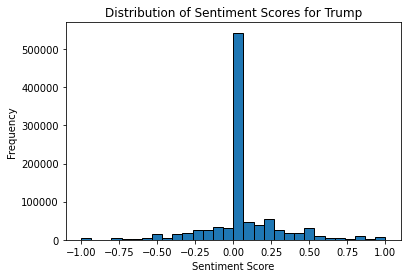

In [58]:
plt.hist(df_parquet_results_trump['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')
plt.show()

## Biden

In [59]:
# Examine Biden Sentiment distribution
df_parquet_results_biden['sentiment'].value_counts()

 0.000000    298713
 0.500000     13481
 0.800000      9016
 0.300000      7527
 0.250000      6934
              ...  
 0.021429         1
 0.747500         1
 0.153241         1
-0.126042         1
 0.201852         1
Name: sentiment, Length: 12118, dtype: int64

In [60]:
# look at sample of tweets for each outcome
df_parquet_results_biden[df_parquet_results_biden['sentiment'] < 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
9,"""@ossoff @common 3 Trillion Stimulus will be p...",tweet,<NA>,Biden,-0.300000
20,@SteveGuest So is #TonyBobulinski lying when h...,tweet,2020-10-09 19:24:36,Biden,-0.400000
31,"""The war in #Yemen may not last long into a #B...",tweet,<NA>,Biden,-0.025000
39,"""@MSNBC Total crap and #fakenews. The laptop ...",tweet,2020-10-20 19:52:13,Biden,-0.100000
50,Over #250k dead Americans endorse #joebiden fr...,tweet,"""Dallas",Biden,-0.031818


In [61]:
df_parquet_results_biden[df_parquet_results_biden['sentiment'] == 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden,0.0
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden,0.0
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden,0.0
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden,0.0
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden,0.0


In [62]:
df_parquet_results_biden[df_parquet_results_biden['sentiment'] > 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
8,Is it true? #Biden https://t.co/ly76Q5NVgm,tweet,<NA>,Biden,0.350000
15,You’re not black if you don’t vote Democrat -B...,tweet,,Biden,0.083333
21,Michigan Democratic Rep. Dingell: 'So many' au...,tweet,,Biden,0.500000
38,"""Vote #Biden if you like to pay more taxes. If...",tweet,<NA>,Biden,0.500000
48,Rounding the curve so much we’re going in circ...,tweet,31.0,Biden,0.200000


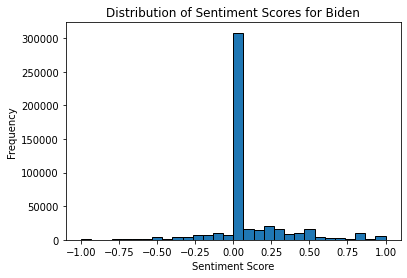

In [63]:
plt.hist(df_parquet_results_biden['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')
plt.show()

## Word Clouds with Sentiment

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from textblob import TextBlob

# Function to preprocess text and remove specific terms
def preprocess_text(text, words_to_exclude, patterns_to_exclude):
    # Remove specific words
    text = ' '.join([word for word in text.split() if word.lower() not in words_to_exclude])
    # Remove patterns
    for pattern in patterns_to_exclude:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    return text

# Function to generate word cloud for given text
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Define words and patterns to exclude
trump_words_to_exclude = ['trump', 'donald', 'donaldtrump', 'DonaldTrump', 'https', 'co', 'S', 's']
trump_patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

biden_words_to_exclude = ['biden', 'joe', 'joebiden', 'https', 'co', 'S', 's']
biden_patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Sample size for comments
sample_size = 10000

# Subset total data for Trump and Biden
trump_comments = df_parquet_results_trump['comment_body'].dropna().sample(n=sample_size, random_state=42)
biden_comments = df_parquet_results_biden['comment_body'].dropna().sample(n=sample_size, random_state=42)

# Apply sentiment analysis and add sentiment column for Trump
trump_sentiments = trump_comments.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_parquet_results_trump['sentiment'] = trump_sentiments

# Apply sentiment analysis and add sentiment column for Biden
biden_sentiments = biden_comments.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_parquet_results_biden['sentiment'] = biden_sentiments

# Filter Trump comments based on positive and negative sentiment and preprocess text
trump_positive_comments = trump_comments[df_parquet_results_trump['sentiment'] > 0].apply(preprocess_text, args=(trump_words_to_exclude, trump_patterns_to_exclude))
trump_negative_comments = trump_comments[df_parquet_results_trump['sentiment'] < 0].apply(preprocess_text, args=(trump_words_to_exclude, trump_patterns_to_exclude))

# Filter Biden comments based on positive and negative sentiment and preprocess text
biden_positive_comments = biden_comments[df_parquet_results_biden['sentiment'] > 0].apply(preprocess_text, args=(biden_words_to_exclude, biden_patterns_to_exclude))
biden_negative_comments = biden_comments[df_parquet_results_biden['sentiment'] < 0].apply(preprocess_text, args=(biden_words_to_exclude, biden_patterns_to_exclude))

# Combine positive and negative comments for Trump and Biden
trump_positive_text = ' '.join(trump_positive_comments)
trump_negative_text = ' '.join(trump_negative_comments)
biden_positive_text = ' '.join(biden_positive_comments)
biden_negative_text = ' '.join(biden_negative_comments)

# Generate word clouds
generate_word_cloud(trump_positive_text, 'Word Cloud for Positive Trump Comments (Excluding "Donald Trump")')
generate_word_cloud(trump_negative_text, 'Word Cloud for Negative Trump Comments (Excluding "Donald Trump")')
generate_word_cloud(biden_positive_text, 'Word Cloud for Positive Biden Comments (Excluding "Joe Biden")')
generate_word_cloud(biden_negative_text, 'Word Cloud for Negative Biden Comments (Excluding "Joe Biden")')
